# Required Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
import math
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Data Gathering

In [2]:
bike_sharing = fetch_ucirepo(id=275)
df = bike_sharing.data.original

In [4]:
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


# Data Wrangling

In [8]:
new_column_names = {
    'dteday':'date',
    'season': 'season',
    'yr': 'year',
    'mnth': 'month',
    'hr': 'hour',
    'holiday': 'holiday',
    'weekday': 'weekday',
    'workingday': 'working_day',
    'weathersit': 'weather_situation',
    'temp': 'temperature',
    'atemp': 'feels_like_temperature',
    'hum': 'humidity',
    'windspeed': 'wind_speed',
    'cnt':'count'
}

# Rename columns
df.rename(columns=new_column_names, inplace=True)

In [9]:
df['date'] = pd.to_datetime(df['date'])
df['season'] = df.season.astype('category')
df['month'] = df.month.astype('category')
df['year'] = df.year.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['working_day'] = df.working_day.astype('category')
df['weather_situation'] = df.weather_situation.astype('category')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['feels_like_temperature'] = pd.to_numeric(df['feels_like_temperature'], errors='coerce')

#### The code performs data cleaning and transformation operations on the dataframe including renaming columns, converting data types, replacing numerical codes with categorical labels.

# Outlier Detection

In [11]:
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df[(df['count'] < lower_bound) | (df['count'] > upper_bound)]
outliers.style.background_gradient(cmap='Greys')
df = df[(df['count'] >= lower_bound) & (df['count'] <= upper_bound)]
df = df.reset_index(drop=True)

# Scaling up of the normalized values for Data Visualization Plots

In [12]:
df.loc[:,['temperature']] = df.loc[:,['temperature']].apply(lambda x: 47*x -8)

In [13]:
df.loc[:,['feels_like_temperature']] = df.loc[:,['feels_like_temperature']].apply(lambda x: 66*x -16)

In [14]:
df.loc[:,['humidity']]=df.loc[:,['humidity']]

In [15]:
df.loc[:,['wind_speed']]= df.loc[:,['wind_speed']]*100

In [16]:
df

,instant,date,season,year,month,hour,holiday,weekday,working_day,weather_situation,temperature,feels_like_temperature,humidity,wind_speed,casual,registered,count
0,1,2011-01-01,Winter,2011,Jan,0,0,Saturday,No,Clear,3.28,3.0014,0.81,0.00,3,13,16
1,2,2011-01-01,Winter,2011,Jan,1,0,Saturday,No,Clear,2.34,1.9982,0.80,0.00,8,32,40
2,3,2011-01-01,Winter,2011,Jan,2,0,Saturday,No,Clear,2.34,1.9982,0.80,0.00,5,27,32
3,4,2011-01-01,Winter,2011,Jan,3,0,Saturday,No,Clear,3.28,3.0014,0.75,0.00,3,10,13
4,5,2011-01-01,Winter,2011,Jan,4,0,Saturday,No,Clear,3.28,3.0014,0.75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16869,17375,2012-12-31,Winter,2012,Dec,19,0,Monday,Yes,Misty,4.22,1.0016,0.60,16.42,11,108,119
16870,17376,2012-12-31,Winter,2012,Dec,20,0,Monday,Yes,Misty,4.22,1.0016,0.60,16.42,8,81,89
16871,17377,2012-12-31,Winter,2012,Dec,21,0,Monday,Yes,Clear,4.22,1.0016,0.60,16.42,7,83,90
16872,17378,2012-12-31,Winter,2012,Dec,22,0,Monday,Yes,Clear,4.22,1.9982,0.56,13.43,13,48,61


In [23]:
df = df.loc[:, ~df.columns.isin(['instant', 'date', 'month'])]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16874 entries, 0 to 16873
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   season                  16874 non-null  category
 1   year                    16874 non-null  category
 2   hour                    16874 non-null  int64   
 3   holiday                 16874 non-null  category
 4   weekday                 16874 non-null  category
 5   working_day             16874 non-null  category
 6   weather_situation       16874 non-null  category
 7   temperature             16874 non-null  float64 
 8   feels_like_temperature  16874 non-null  float64 
 9   humidity                16874 non-null  float64 
 10  wind_speed              16874 non-null  float64 
 11  casual                  16874 non-null  int64   
 12  registered              16874 non-null  int64   
 13  count                   16874 non-null  int64   
dtypes: category(6), float6

In [26]:
df

,season,year,hour,holiday,weekday,working_day,weather_situation,temperature,feels_like_temperature,humidity,wind_speed,casual,registered,count
0,1,1,0,1,7,1,1,3.28,3.0014,0.81,0.00,3,13,16
1,1,1,1,1,7,1,1,2.34,1.9982,0.80,0.00,8,32,40
2,1,1,2,1,7,1,1,2.34,1.9982,0.80,0.00,5,27,32
3,1,1,3,1,7,1,1,3.28,3.0014,0.75,0.00,3,10,13
4,1,1,4,1,7,1,1,3.28,3.0014,0.75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16869,1,2,19,1,2,2,2,4.22,1.0016,0.60,16.42,11,108,119
16870,1,2,20,1,2,2,2,4.22,1.0016,0.60,16.42,8,81,89
16871,1,2,21,1,2,2,1,4.22,1.0016,0.60,16.42,7,83,90
16872,1,2,22,1,2,2,1,4.22,1.9982,0.56,13.43,13,48,61


# One hot Encoding for categorical variables

In [27]:
categorical_features = ['season', 'year', 'weekday', 'weather_situation', 'working_day']

# Initialize the ColumnTransformer with OneHotEncoder for the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), categorical_features)  # drop='first' to avoid dummy variable trap
    ],
    remainder='passthrough'  # Leave the rest of the columns unchanged
)

# Fit and transform the DataFrame
df_encoded = preprocessor.fit_transform(df)

# The output of fit_transform is a NumPy array, to convert it back to DataFrame:
# Get the new column names after one-hot encoding
onehot_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features)
remainder_columns = [col for col in df.columns if col not in categorical_features]
new_column_names = list(onehot_columns) + remainder_columns

# Create a new DataFrame with the transformed data
df = pd.DataFrame(df_encoded, columns=new_column_names)

# Feature Engineering

In [28]:
df['i_hour'] = df['hour'].apply(lambda x: 1 if (7 <= x <= 10) or (16 <= x <= 20) else 0)

In [29]:
X = df.drop(['count'], axis=1)
y = df['count']

# Data Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
print("shape of x_train",X_train.shape)
print("shape of y_train",y_train.shape)
print("shape of x_test",X_test.shape)
print("shape of y_test",y_test.shape)

shape of x_train (13499, 23)
shape of y_train (13499,)
shape of x_test (3375, 23)
shape of y_test (3375,)


In [31]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Data Modelling 

Evaluating model: LR
Average MSE: 1.2173610803275353e-26, Std: 9.427237682893722e-27
Average MAE: 7.522982825489588e-14, Std: 3.524766135436445e-14
Average RMSE: 1.0054393161003074e-13, Std: 4.5437084189820275e-14
Average R-squared: 1.0, Std: 0.0



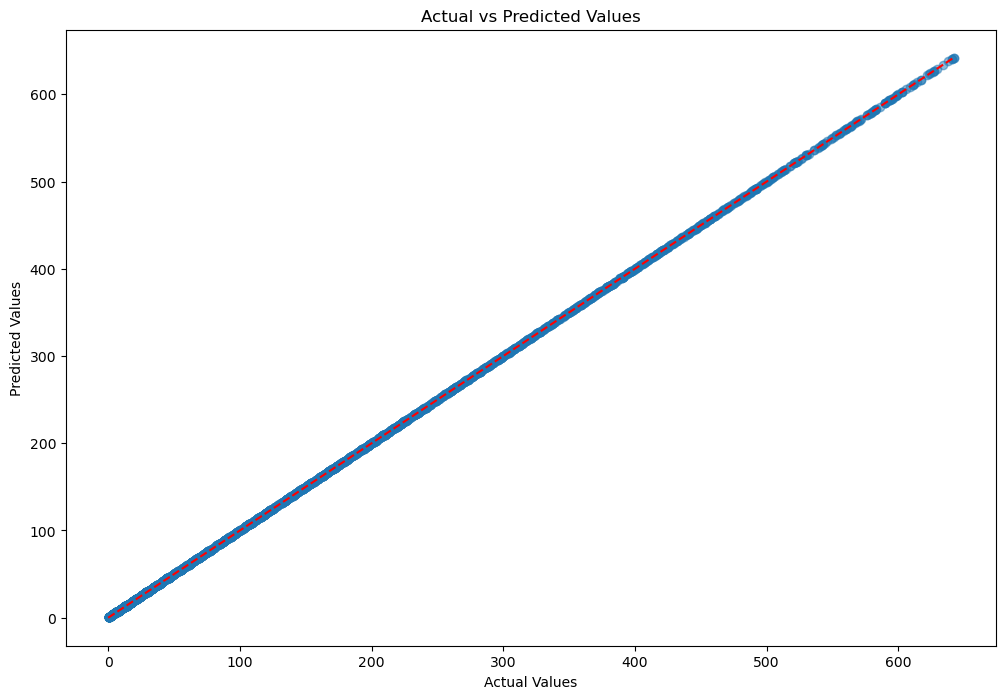

Evaluating model: KNN


C:\Users\Mehul\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\Users\Mehul\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, 

Average MSE: 16.82947787488501, Std: 0.570508816662595
Average MAE: 2.9371601029247856, Std: 0.03983885343469711
Average RMSE: 4.10178636884812, Std: 0.06947272282534038
Average R-squared: 0.9992992682493789, Std: 3.0350270848645726e-05



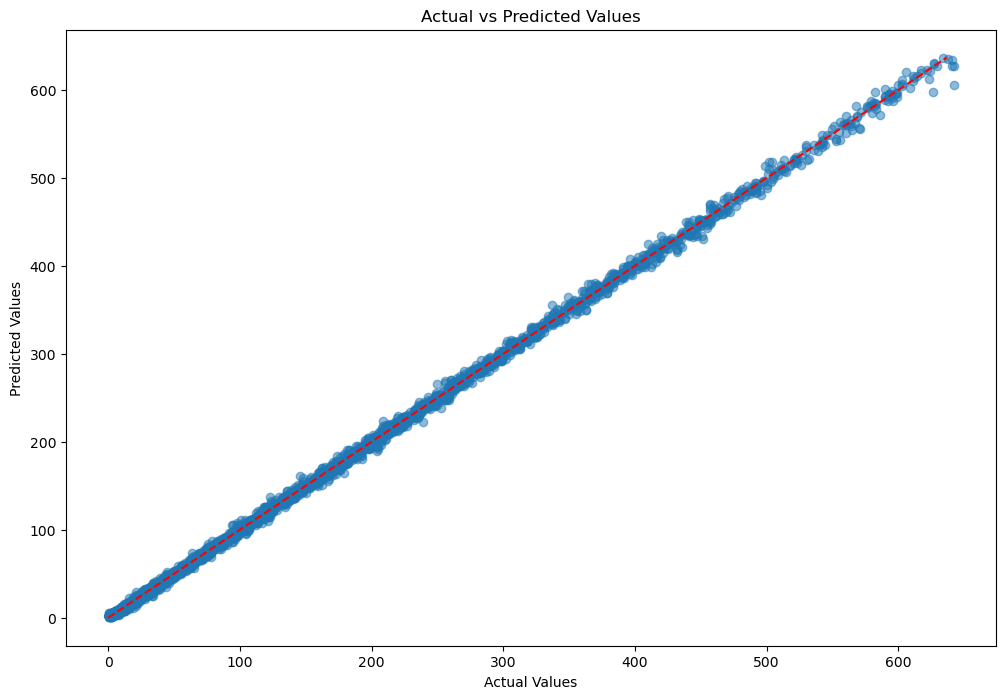

Evaluating model: SVM
Average MSE: 119.0377636470791, Std: 17.836083227158458
Average MAE: 3.2749114120341667, Std: 0.21324583218314314
Average RMSE: 10.87813667085762, Std: 0.8389911901932227
Average R-squared: 0.995054096685725, Std: 0.0006876371043022898



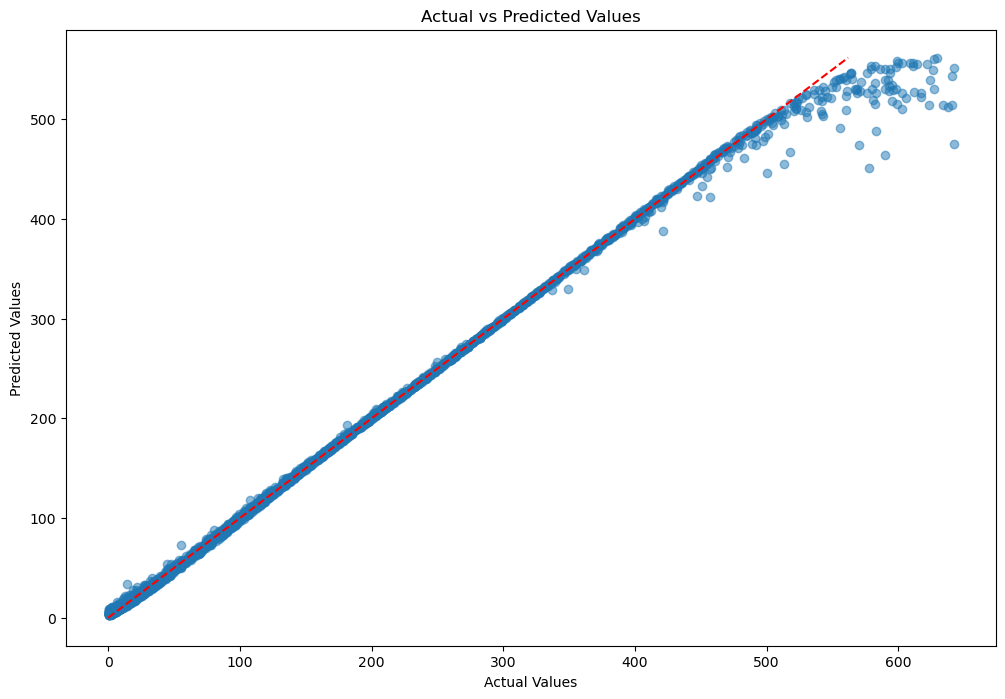

Evaluating model: Decision Tree
Average MSE: 14.936147803743273, Std: 0.5932757138013398
Average MAE: 1.9282892145237085, Std: 0.03497485269885887
Average RMSE: 3.863983916603211, Std: 0.07600063141175006
Average R-squared: 0.9993780482992317, Std: 3.1247259871413275e-05



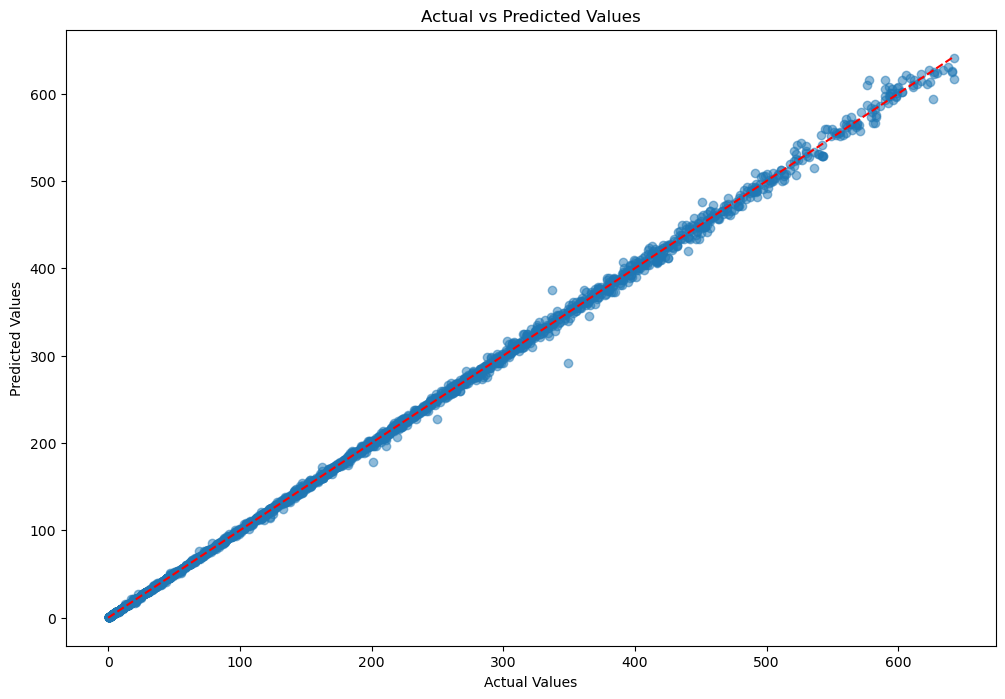

Evaluating model: Random Forest
Average MSE: 4.160032919148498, Std: 1.2079931005043363
Average MAE: 0.8410936817596686, Std: 0.04200393195950329
Average RMSE: 2.020685885586874, Std: 0.27723901409882473
Average R-squared: 0.9998271468958023, Std: 4.830344417354412e-05



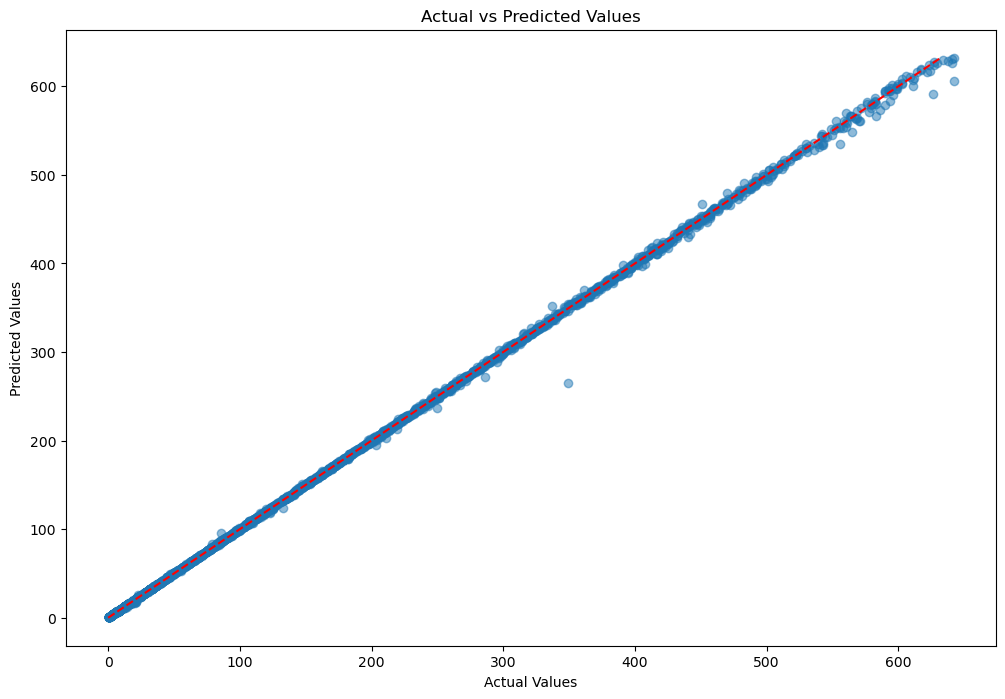

In [32]:
models = {
    'LR': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=3, metric='manhattan'),
    'SVM': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

kf = KFold(n_splits=6, shuffle=True, random_state=42)
dict_models = {}
for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    mse_scores = []
    mae_scores = []
    rmse_scores = []
    r2_scores = []
    if model_name=='KNN':
        joblib.parallel_backend('loky', n_jobs=-1)  # Use all available cores

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    average_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    average_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    average_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    average_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)


    #residuals = actual - predicted

    
    dict_models[model_name] = [average_mse,average_mae,average_rmse,average_r2]
    print(f"Average MSE: {average_mse}, Std: {std_mse}")
    print(f"Average MAE: {average_mae}, Std: {std_mae}")
    print(f"Average RMSE: {average_rmse}, Std: {std_rmse}")
    print(f"Average R-squared: {average_r2}, Std: {std_r2}\n")
    plt.figure(figsize=(12, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([0, max(y_pred)], [0, max(y_pred)], 'r--')  # Line for y=x
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

# Model Evaluation

In [33]:
pd.DataFrame(dict_models,index = ['MSE','RMSE','MAE','R2']).transpose()

,MSE,RMSE,MAE,R2
LR,1.217361e-26,7.522983e-14,1.005439e-13,1.000000
KNN,1.682948e+01,2.937160e+00,4.101786e+00,0.999299
SVM,1.190378e+02,3.274911e+00,1.087814e+01,0.995054
Decision Tree,1.493615e+01,1.928289e+00,3.863984e+00,0.999378
Random Forest,4.160033e+00,8.410937e-01,2.020686e+00,0.999827


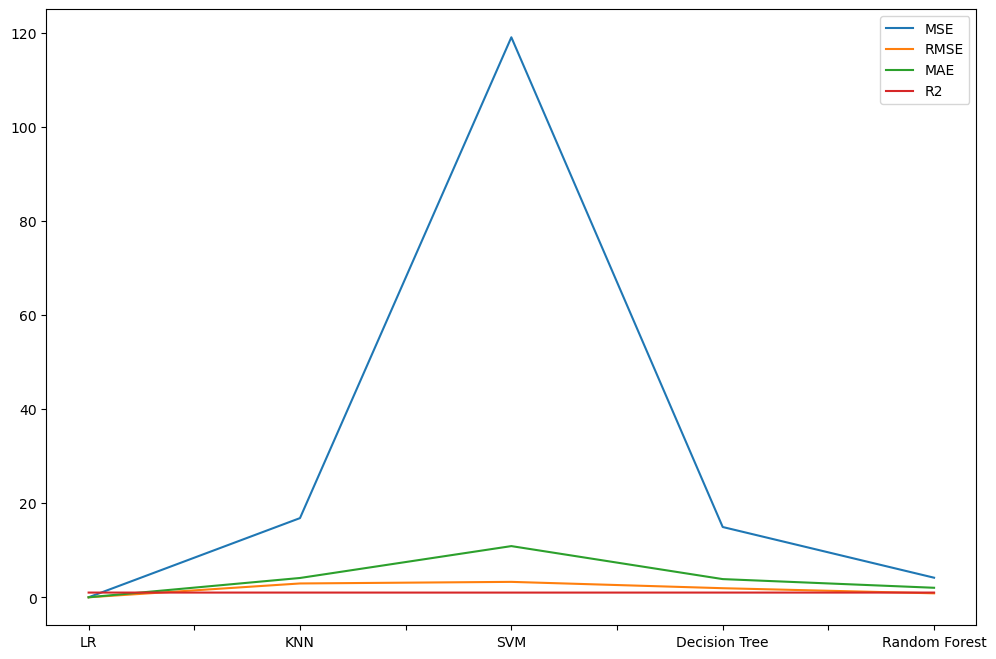

In [34]:
plt.figure(figsize=(12, 8))
for col in pd.DataFrame(dict_models,index = ['MSE','RMSE','MAE','R2']).transpose():
    pd.DataFrame(dict_models,index = ['MSE','RMSE','MAE','R2']).transpose()[col].plot(legend=True)

## Optimal Model Selection Pickle file

### Choosing the Best Model for a Business Case
#### Fundamentals of Metrics

##### MSE (Mean Squared Error): Measures the average squared difference between the predicted and actual values.
##### RMSE (Root Mean Squared Error): The square root of MSE, providing a measure in the same units as the dependent variable.
##### MAE (Mean Absolute Error): Measures the average absolute difference between the predicted and actual values.
##### R-squared (R2): Represents the proportion of variance in the dependent variable that is predictable from the independent variable(s).

#### Model Selection: Random Forest is the preferred choice for this business case due to its ability to provide accurate and reliable predictions making it a valuable tool for this specific business case.

#### Reasons:

##### Low MAE: Random Forest has the lowest Mean Absolute Error (MAE) among the presented models. This implies that, on average, its predictions are closest to the actual values, making it suitable for business decisions that rely on accurate predictions.
##### High R-squared: The Random Forest model also exhibits a high R-squared value, indicating that it explains a significant portion of the variance in the data. This suggests good predictive power.
##### Robustness: Random Forest is generally robust to outliers and overfitting, making it less prone to making extreme predictions.
##### Mean Absolute Deviations
###### The Mean Absolute Error (MAE) for the Random Forest model is 2.020686e+00.


# Pickle file for deployment using Flask

In [35]:
import pickle

# Save the model to a pickle file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(models['Random Forest'], f)